In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import nbimporter
import time
import os
# import pywt

from scipy.signal import butter, filtfilt, medfilt, savgol_filter as sg_builtin
from scipy.ndimage import gaussian_filter1d

from code_ import savgol_filter, read_csv_multi
from snr import compute_snr
from RMSE import compute_rmse


Filter Performance:
Savitzky–Golay  SNR= 34.72 dB   RMSE=2.0339
Moving Average  SNR= 20.29 dB   RMSE=10.3306
Gaussian        SNR= 24.32 dB   RMSE=6.5917
Butterworth     SNR= 29.38 dB   RMSE=3.7593
Median          SNR= 28.05 dB   RMSE=4.3457
Wavelet         SNR= 22.93 dB   RMSE=7.6454


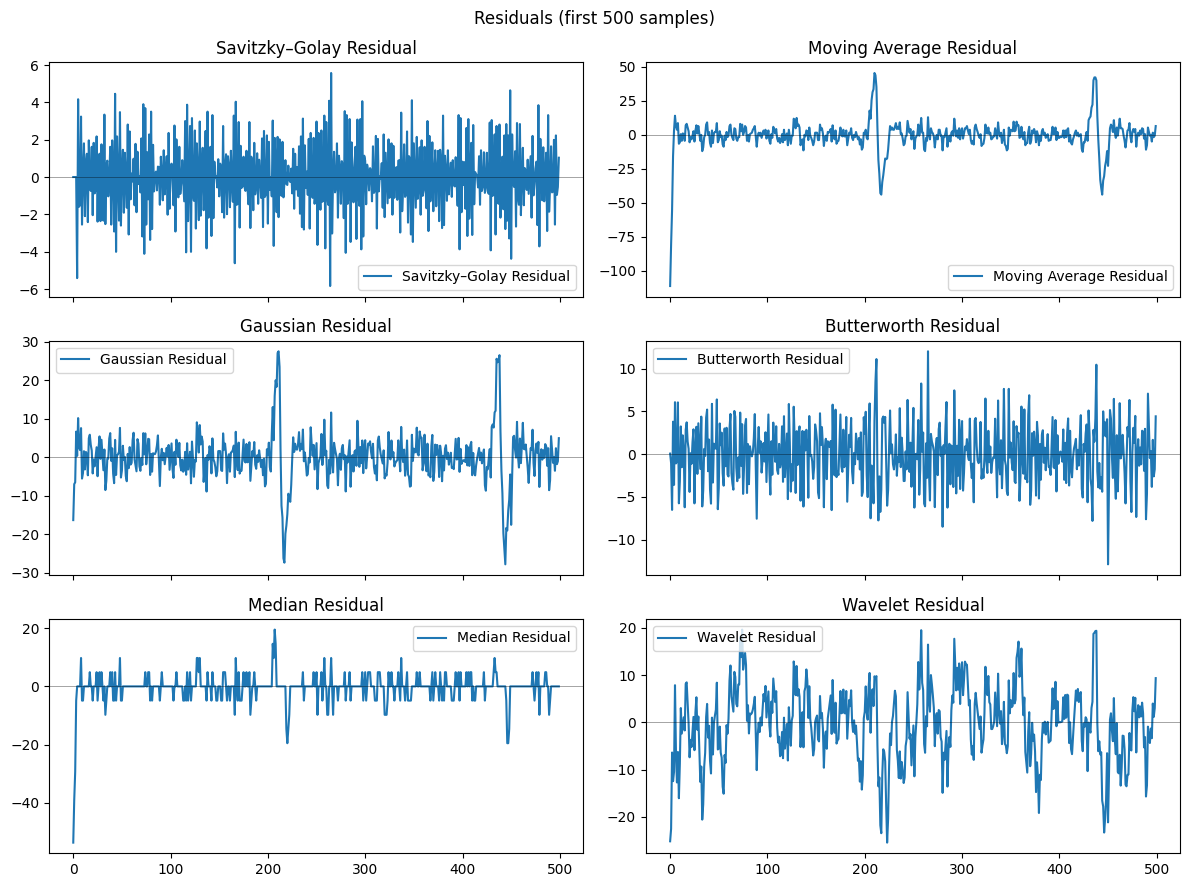

In [ ]:
def moving_average(sig, w=5):
    return np.convolve(sig, np.ones(w)/w, mode='same')

def gaussian_filter(sig, sigma=2):
    return gaussian_filter1d(sig, sigma)

def butterworth_filter(sig, cutoff=40, fs=360, order=4):
    nyq = 0.5*fs
    b, a = butter(order, cutoff/nyq, btype='low')
    return filtfilt(b, a, sig)

def median_filter(sig, w=5):
    return medfilt(sig, kernel_size=w)

def wavelet_denoise(sig, wavelet='db6', level=3):
    coeffs = pywt.wavedec(sig, wavelet, mode='per')
    sigma = np.median(np.abs(coeffs[-1]))/0.6745
    uth   = sigma*np.sqrt(2*np.log(len(sig)))
    coeffs[1:] = [pywt.threshold(c, value=uth, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet, mode='per')

# ---------- main -------------
file = 'ECGData/MUSE_20180111_155115_19000.csv'
signal = np.array(read_csv_multi(file)[0])

window, poly = 9, 6
filtered = {
    'Savitzky–Golay': savgol_filter(signal, window, poly),
    'Moving Average' : moving_average(signal, window),
    'Gaussian'       : gaussian_filter(signal, sigma=2),
    'Butterworth'    : butterworth_filter(signal, cutoff=40, fs=360, order=4),
    'Median'         : median_filter(signal, window),
    'Wavelet'        : wavelet_denoise(signal)
}

print("\nFilter Performance:")
for name, sig_f in filtered.items():
    print(f"{name:<14}  SNR={compute_snr(signal, sig_f):6.2f} dB   RMSE={compute_rmse(signal, sig_f):.4f}")


t   = np.arange(500)     
seg = slice(0, 500)       

n    = len(filtered)
rows = int(np.ceil(n / 2))
fig, axs = plt.subplots(rows, 2, figsize=(12, 3 * rows), sharex=True)
axs = axs.flatten()

for ax, (name, sig_f) in zip(axs, filtered.items()):
    res = signal[seg] - sig_f[seg]
    ax.plot(t, res, label=f'{name} Residual')
    ax.axhline(0, color='k', lw=0.5, alpha=0.5)
    ax.set_title(f'{name} Residual')
    ax.legend()

fig.suptitle('Residuals (first 500 samples)')
plt.tight_layout()
plt.show()


In [94]:
def compute_psnr(original, denoised):
    """
    Computes Peak Signal-to-Noise Ratio (PSNR) in decibels between original and denoised signals.
    """
    original = np.array(original)
    denoised = np.array(denoised)
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return np.inf
    peak = np.max(original) - np.min(original)
    return 10 * np.log10((peak ** 2) / mse)

In [107]:
filters = {
    'Savitzky–Golay': lambda sig: savgol_filter(sig, window_size=11, poly_order=8),
    'Moving Average': lambda sig: moving_average(sig, 11),
    'Gaussian': lambda sig: gaussian_filter(sig, sigma=2),
    'Butterworth': lambda sig: butterworth_filter(sig, cutoff=40, fs=360, order=4)
}


folder = 'ECGData'
files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.csv')])[:10]


accumulators = {method: {'SNR': 0, 'RMSE': 0, 'PSNR': 0, 'Time': 0} for method in filters}
num_signals = 0


for file in files:
    channels = read_csv_multi(file)
    for ch in channels[:3]:  
        signal = np.array(ch[:2000])  
        for name, func in filters.items():
            start = time.time()
            filtered = func(signal)
            elapsed_ms = (time.time() - start) * 1000
            snr = compute_snr(signal, filtered)
            rmse = compute_rmse(signal, filtered)
            psnr = compute_psnr(signal, filtered)

            accumulators[name]['SNR'] += snr
            accumulators[name]['RMSE'] += rmse
            accumulators[name]['PSNR'] += psnr
            accumulators[name]['Time'] += elapsed_ms

        num_signals += 1
        
results = []
for name, metrics in accumulators.items():
    results.append({
        'Method': name,
        'SNR (dB)': round(metrics['SNR'] / num_signals, 2),
        'RMSE': round(metrics['RMSE'] / num_signals, 4),
        'PSNR': round(metrics['PSNR'] / num_signals, 4),
        'Time (ms)': round(metrics['Time'] / num_signals, 2)
    })

df = pd.DataFrame(results)
print(df.to_string(index=False))

        Method  SNR (dB)    RMSE    PSNR  Time (ms)
Savitzky–Golay     30.76  4.7431 48.1311       3.17
Moving Average     11.42 36.8974 29.7766       0.02
      Gaussian     16.54 21.6679 34.4231       0.04
   Butterworth     18.82 17.6950 36.3350       0.19


Max |custom - built| = 4.841225e+00
RMS difference      = 1.674637e-01


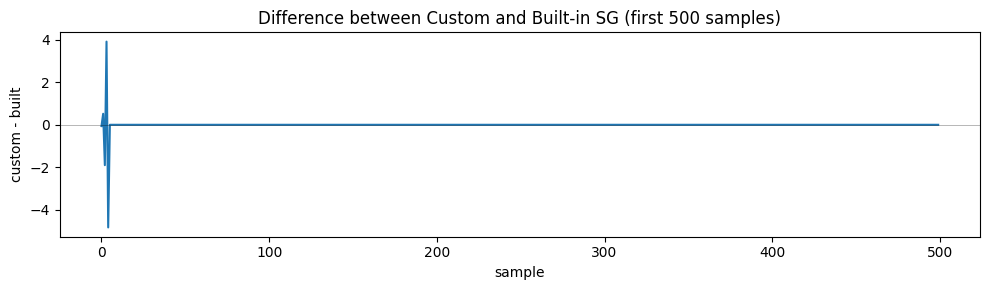

In [96]:
# ---------- parameters ----------
w,p=11,8
cust=savgol_filter(signal,w,p)
built=sg_builtin(signal,window_length=w,polyorder=p,mode='interp')

# ---------- difference -------------
diff_signal = cust - built
max_abs=np.max(np.abs(diff_signal))
rms=np.sqrt(np.mean(diff_signal**2))

print(f"Max |custom - built| = {max_abs:.6e}")
print(f"RMS difference      = {rms:.6e}")

seg=slice(0,500)
plt.figure(figsize=(10,3))
plt.plot(np.arange(500), diff_signal[seg])
plt.axhline(0,color='k',lw=0.5,alpha=0.4)
plt.title('Difference between Custom and Built‑in SG (first 500 samples)')
plt.xlabel('sample')
plt.ylabel('custom - built')
plt.tight_layout()
plt.show()
